# MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles
This is the code for the paper entitled "[**MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles**](https://arxiv.org/pdf/2105.13289.pdf)" accepted in IEEE Internet of Things Journal.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, and A. Shami, “MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles,” IEEE Internet of Things Journal, vol. 9, no. 1, pp. 616-632, Jan.1, 2022.

## Import libraries

In [1]:
# Uninstall NumPy if it's already installed
!pip uninstall numpy -y

# Restrict NumPy to version 1.26.4
!pip install numpy==1.26.4

# Install core dependencies
!pip install pandas seaborn matplotlib scipy

# Machine learning libraries
!pip install scikit-learn xgboost imbalanced-learn

# Hyperparameter optimization libraries
!pip install hyperopt scikit-optimize

# Install custom module FCBF from GitHub
!pip install git+https://github.com/SantiagoEG/FCBF_module.git


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
  Cloning https://github.com/SantiagoEG/FCBF_module.git to c:\users\logan\appdata\local\temp\pip-req-build-0fdyogrb
  Resolved https://github.com/SantiagoEG/FCBF_module.git to commit 092b60b65ee6ceaf9b0227d12b575f2a3336b287


  Running command git clone --filter=blob:none --quiet https://github.com/SantiagoEG/FCBF_module.git 'C:\Users\Logan\AppData\Local\Temp\pip-req-build-0fdyogrb'
ERROR: git+https://github.com/SantiagoEG/FCBF_module.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif
from FCBF_module import FCBF, FCBFK

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay
)

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [4]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017_sample.csv') 
# The results in this code is based on the original CICIDS2017 dataset. Please go to cell [21] if you work on the sampled dataset. 

In [5]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [6]:
df.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)

In [7]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [8]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [9]:
df.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

In [10]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [11]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [12]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [13]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [14]:
df_major['klabel'].value_counts()

klabel
20     482
842    411
312    348
324    337
745    334
      ... 
149      1
879      1
100      1
727      1
71       1
Name: count, Length: 979, dtype: int64

In [15]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [16]:
df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.528470,-0.068426,-0.081806,-0.032573,-0.048343,-0.202326,-0.085798,-0.141625,-0.176448,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,402,0
1,-0.524593,0.704878,0.850340,0.027749,0.920410,0.603275,-0.211174,-0.082434,0.240596,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
2,-0.525233,0.300651,0.339163,0.020443,0.363712,0.603275,-0.211174,0.044064,0.439619,0.484295,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,191,0
3,-0.524560,0.652153,0.745098,0.026625,0.933533,0.603275,-0.211174,-0.074097,0.257378,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
4,-0.524555,0.757604,0.805237,0.028030,0.960037,0.603275,-0.211174,-0.091861,0.225734,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,-0.528463,-0.068426,-0.051737,-0.031309,-0.046220,-0.200831,0.457498,-0.064078,-0.255104,-0.517901,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,231,0
56657,-0.524840,-0.068426,-0.051737,-0.029904,-0.043932,-0.178412,0.770939,0.022086,-0.255104,-0.472838,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,934,0
56658,-0.215111,-0.015701,-0.021667,-0.013231,-0.016083,0.423920,-0.211174,0.269089,0.640328,0.711051,...,-0.108682,-0.081786,-0.127669,-0.093554,-0.256386,-0.137651,-0.269448,-0.238252,551,3
56659,-0.215111,0.037025,0.008402,-0.014823,0.058109,0.373103,-0.211174,0.050807,0.399311,1.528310,...,-0.108677,-0.081786,-0.127664,-0.093548,-0.256402,-0.137651,-0.269464,-0.238268,702,3


In [17]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [18]:
result['Label'].value_counts()

Label
0    121
3    118
5     56
2     20
Name: count, dtype: int64

In [19]:
result

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
48257,1.828203,0.037025,0.008402,-0.017399,0.057771,0.281931,-0.211174,0.011316,0.302081,1.532275,...,-0.108545,-0.081786,-0.127561,-0.093406,2.201366,-0.137651,2.123313,2.237269,2,3
21288,-0.522684,-0.086001,-0.066771,-0.032573,-0.047519,-0.193358,0.561979,-0.035356,-0.255104,-0.527274,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,8,0
5736,-0.477322,-0.050851,-0.021667,-0.033088,0.057881,-0.218767,-0.211174,-0.198110,-0.209439,3.620304,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,10,3
1124,-0.348074,-0.015701,-0.081806,-0.032901,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.104474,-0.081786,-0.124354,-0.089001,-0.252740,-0.137651,-0.265899,-0.234580,11,3
743,-0.501184,-0.033276,-0.081806,-0.033182,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16723,-0.527787,-0.068426,-0.051737,-0.030747,-0.046879,-0.191864,0.582875,-0.029612,-0.255104,-0.530879,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,979,0
6550,-0.199371,-0.015701,-0.081806,-0.032901,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.103114,-0.081786,-0.123282,-0.087529,-0.082271,-0.137651,-0.099937,-0.062878,982,3
52586,-0.527070,-0.015701,-0.081806,-0.034306,-0.048343,-0.248659,-0.211174,-0.247894,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,991,3
10170,-0.528469,-0.086001,-0.066771,-0.034212,-0.048288,-0.245670,-0.169382,-0.236405,-0.255104,-0.557556,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,997,5


In [20]:
import pandas as pd

# Assuming 'result' and 'df_minor' are already defined and loaded

# No need to drop 'klabel' since it doesn't exist
# If you need to drop another column, ensure it exists
# For example, to drop 'Label' (only if intended, which is usually not the case):
# result = result.drop(['Label'], axis=1)

# Concatenate 'result' and 'df_minor' DataFrames
result = pd.concat([result, df_minor], ignore_index=True)

print("DataFrames concatenated successfully.")
print("Updated DataFrame head:")
print(result.head())

DataFrames concatenated successfully.
Updated DataFrame head:
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0       1.828203           0.037025                0.008402   
1      -0.522684          -0.086001               -0.066771   
2      -0.477322          -0.050851               -0.021667   
3      -0.348074          -0.015701               -0.081806   
4      -0.501184          -0.033276               -0.081806   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                    -0.017399                     0.057771   
1                    -0.032573                    -0.047519   
2                    -0.033088                     0.057881   
3                    -0.032901                    -0.048343   
4                    -0.033182                    -0.048343   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0               0.281931              -0.211174                0.011316   
1              -0.193358      

In [21]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### split train set and test set

In [22]:
# Read the sampled dataset
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')
print(df.isnull().sum())

Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
                               ... 
Idle Std                          0
Idle Max                          0
Idle Min                          0
klabel                         4182
Label                             0
Length: 79, dtype: int64


In [23]:
from sklearn.impute import SimpleImputer

# Create an imputer object with the desired strategy (mean, median, most_frequent)
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the DataFrame
df[df.columns] = imputer.fit_transform(df)

In [24]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [26]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [27]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [28]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [29]:
X_fs = df[fs].values

In [30]:
X_fs.shape

(4497, 41)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [31]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [32]:
X_fss = fcbf.fit_transform(X_fs,y)

In [33]:
X_fss.shape

(4497, 20)

### Re-split train & test sets after feature selection

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [35]:
X_train.shape

(3597, 20)

In [36]:
pd.Series(y_train).value_counts()

6.0    1744
1.0    1572
0.0      97
3.0      94
5.0      45
4.0      29
2.0      16
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [37]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [38]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [39]:
pd.Series(y_train).value_counts()

6.0    1744
1.0    1572
4.0    1000
2.0    1000
0.0      97
3.0      94
5.0      45
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9877777777777778
Precision of XGBoost: 0.9876492631829222
Recall of XGBoost: 0.9877777777777778
F1-score of XGBoost: 0.9873810874479144
              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79        24
         1.0       0.99      1.00      0.99       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      0.96      0.98        24
         4.0       0.62      0.71      0.67         7
         5.0       1.00      1.00      1.00        11
         6.0       0.99      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.93      0.91      0.92       900
weighted avg       0.99      0.99      0.99       900



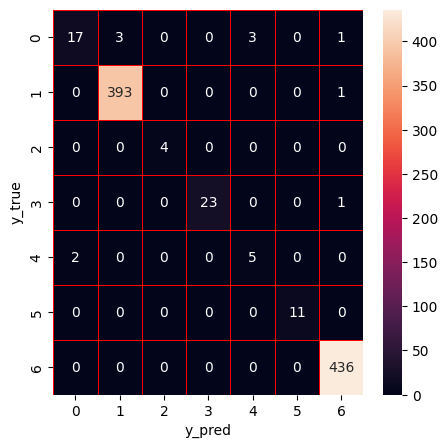

In [40]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [41]:
!pip install hyperopt

In [42]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:02<00:00,  7.08trial/s, best loss: -0.9933333333333333]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.5520667117066604, 'max_depth': 7.0, 'n_estimators': 40.0}


Accuracy of XGBoost: 0.9922222222222222
Precision of XGBoost: 0.9927668900055834
Recall of XGBoost: 0.9922222222222222
F1-score of XGBoost: 0.9919300945967613
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        24
         1.0       0.99      1.00      0.99       394
         2.0       0.80      1.00      0.89         4
         3.0       1.00      1.00      1.00        24
         4.0       0.75      0.86      0.80         7
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.93      0.94      0.93       900
weighted avg       0.99      0.99      0.99       900



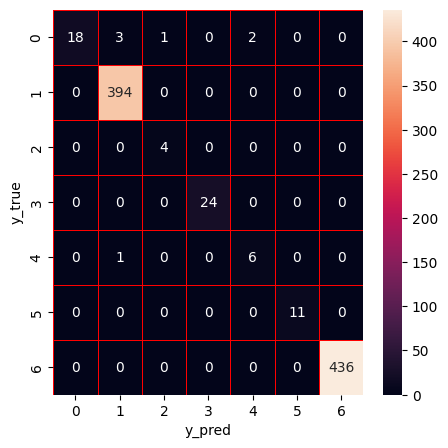

In [43]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [44]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9955555555555555
Precision of RF: 0.9960963697488489
Recall of RF: 0.9955555555555555
F1-score of RF: 0.9955043984861117
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        24
         1.0       1.00      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       0.96      1.00      0.98        24
         4.0       0.78      1.00      0.88         7
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.96      0.98      0.97       900
weighted avg       1.00      1.00      1.00       900



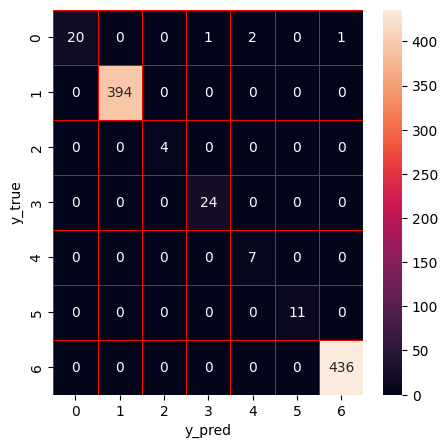

In [45]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [46]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:20<00:00,  1.00s/trial, best loss: -0.9955555555555555]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 50.0, 'max_features': 7.0, 'min_samples_leaf': 1.0, 'min_samples_split': 9.0, 'n_estimators': 92.0}


Accuracy of RF: 0.9944444444444445
Precision of RF: 0.9944875667429443
Recall of RF: 0.9944444444444445
F1-score of RF: 0.9944008983894507
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94        24
         1.0       1.00      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       0.92      0.96      0.94        24
         4.0       1.00      0.86      0.92         7
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.98      0.96      0.97       900
weighted avg       0.99      0.99      0.99       900



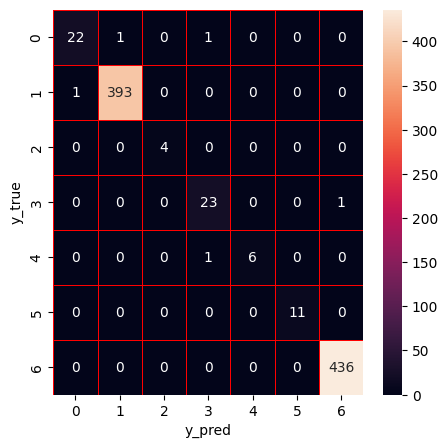

In [47]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [48]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9944444444444445
Precision of DT: 0.9944395279153672
Recall of DT: 0.9944444444444445
F1-score of DT: 0.9943773254784846
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89        24
         1.0       1.00      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       0.92      0.96      0.94        24
         4.0       1.00      0.86      0.92         7
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.98      0.96      0.96       900
weighted avg       0.99      0.99      0.99       900



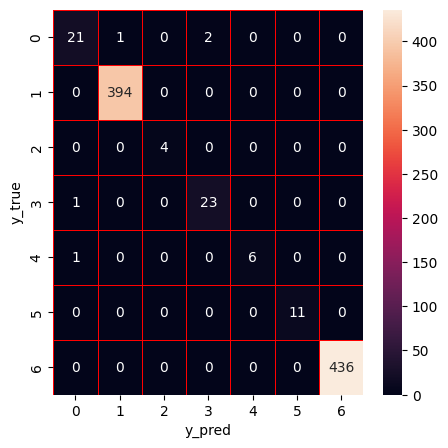

In [49]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [50]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 50/50 [00:01<00:00, 47.14trial/s, best loss: -0.9955555555555555]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 41.0, 'max_features': 12.0, 'min_samples_leaf': 1.0, 'min_samples_split': 8.0}


Accuracy of DT: 0.9911111111111112
Precision of DT: 0.9910576150521231
Recall of DT: 0.9911111111111112
F1-score of DT: 0.9910202837322402
              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85        24
         1.0       0.99      0.99      0.99       394
         2.0       1.00      1.00      1.00         4
         3.0       0.92      0.96      0.94        24
         4.0       1.00      0.86      0.92         7
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.97      0.95      0.96       900
weighted avg       0.99      0.99      0.99       900



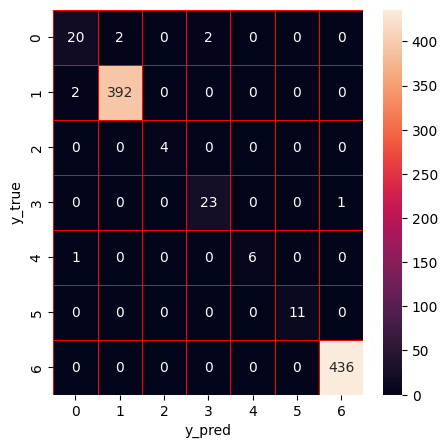

In [51]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [52]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9944444444444445
Precision of ET: 0.994472175949676
Recall of ET: 0.9944444444444445
F1-score of ET: 0.9942493817301468
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        24
         1.0       0.99      1.00      1.00       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00        24
         4.0       0.86      0.86      0.86         7
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.98      0.96      0.97       900
weighted avg       0.99      0.99      0.99       900



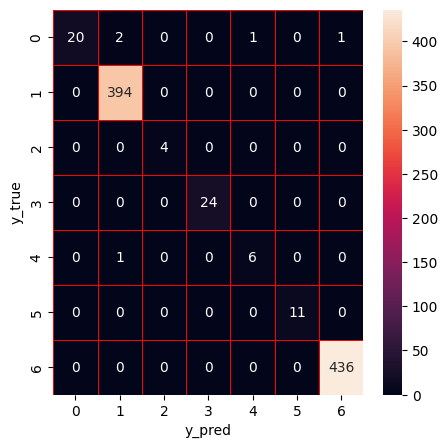

In [53]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [54]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:04<00:00,  4.57trial/s, best loss: -0.9922222222222222]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 29.0, 'max_features': 12.0, 'min_samples_leaf': 1.0, 'min_samples_split': 6.0, 'n_estimators': 40.0}


Accuracy of ET: 0.9911111111111112
Precision of ET: 0.9911437015997864
Recall of ET: 0.9911111111111112
F1-score of ET: 0.9907700652285875
              precision    recall  f1-score   support

         0.0       0.95      0.75      0.84        24
         1.0       0.99      1.00      0.99       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      0.96      0.98        24
         4.0       0.75      0.86      0.80         7
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.96      0.94      0.94       900
weighted avg       0.99      0.99      0.99       900



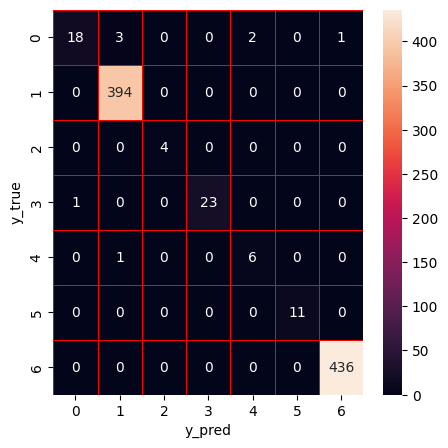

In [55]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [56]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [57]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,6.0,6.0,6.0,6
1,1.0,1.0,1.0,1
2,6.0,6.0,6.0,6
3,6.0,6.0,6.0,6
4,6.0,6.0,6.0,6


In [58]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [59]:
dt_train.shape

(5552, 1)

In [60]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9922222222222222
Precision of Stacking: 0.9920472103717162
Recall of Stacking: 0.9922222222222222
F1-score of Stacking: 0.9919192313079861
              precision    recall  f1-score   support

         0.0       0.95      0.79      0.86        24
         1.0       0.99      1.00      0.99       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      0.96      0.98        24
         4.0       0.86      0.86      0.86         7
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.97      0.94      0.96       900
weighted avg       0.99      0.99      0.99       900



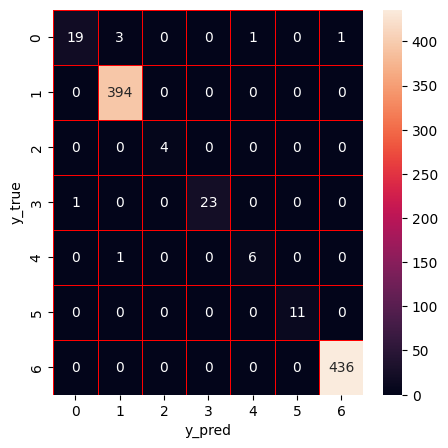

In [61]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [62]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:01<00:00, 19.33trial/s, best loss: -0.9922222222222222]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.21818547784664677, 'max_depth': 81.0, 'n_estimators': 70.0}


Accuracy of XGBoost: 0.9911111111111112
Precision of XGBoost: 0.9911437015997864
Recall of XGBoost: 0.9911111111111112
F1-score of XGBoost: 0.9907700652285875
              precision    recall  f1-score   support

         0.0       0.95      0.75      0.84        24
         1.0       0.99      1.00      0.99       394
         2.0       1.00      1.00      1.00         4
         3.0       1.00      0.96      0.98        24
         4.0       0.75      0.86      0.80         7
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.96      0.94      0.94       900
weighted avg       0.99      0.99      0.99       900



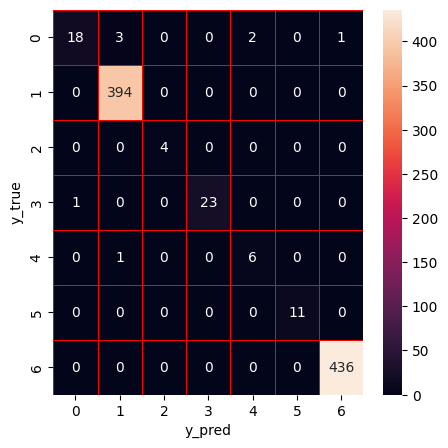

In [63]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [64]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [65]:
df.Label.value_counts()

Label
6    2180
1    1966
0     121
3     118
5      56
4      36
2      20
Name: count, dtype: int64

In [66]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./data/CICIDS2017_sample_km_without_portscan.csv',index=0)

In [67]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('./data/CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [68]:
df1 = pd.read_csv('./data/CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/CICIDS2017_sample_km_portscan.csv')

In [69]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [70]:
df1.Label.value_counts()

Label
1    4320
0     121
Name: count, dtype: int64

In [71]:
df2.Label.value_counts()

Label
1    56
Name: count, dtype: int64

In [72]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [73]:
df2.Label.value_counts()

Label
1    56
0     8
Name: count, dtype: int64

In [74]:
df = pd.concat([df1, df2], ignore_index=True)

In [75]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

1    4376
0     129
Name: count, dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [76]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [77]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [78]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [79]:
X_fs = df[fs].values

In [80]:
X_fs.shape

(4505, 41)

In [81]:
X_fs

array([[-1.23417637, -1.62971605, -0.06305522, ...,  4.81439719,
        -0.21520126, -0.18708437],
       [-1.25404101, -1.60972521, -0.06733832, ..., -0.58188643,
        -0.21511184, -0.18727595],
       [-0.60820358, -1.6030616 , -0.06748373, ..., -0.49766061,
        -0.21516153, -0.02591042],
       ...,
       [-1.25404101,  1.30227288, -0.06703427, ..., -0.75970794,
        -0.06095182, -0.18727587],
       [-1.25404101, -0.56353825, -0.06666413, ..., -0.75971827,
        -0.03415708, -0.18727561],
       [-1.25143969, -1.22656757, -0.06766881, ..., -0.75977437,
        -0.2152026 , -0.18727595]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [82]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [83]:
X_fss = fcbf.fit_transform(X_fs,y)

In [84]:
X_fss.shape

(4505, 20)

In [85]:
X_fss

array([[-1.62971605e+00, -3.16323627e-01, -3.17060442e-01, ...,
         6.16111856e+00,  6.16111856e+00,  3.66146804e+00],
       [-1.60972521e+00,  7.07101994e+00,  7.06859602e+00, ...,
         6.95864231e-02,  6.95864231e-02, -1.10703061e-03],
       [-1.60306160e+00, -3.16323627e-01, -3.17060442e-01, ...,
         9.36557854e+00,  9.36557854e+00,  6.90301636e+00],
       ...,
       [ 1.30227288e+00,  5.67341440e+00,  5.67130966e+00, ...,
         3.40688532e-01,  3.40688532e-01,  1.57420375e-01],
       [-5.63538255e-01,  8.46862548e+00,  8.46588238e+00, ...,
         5.52280421e-01,  5.52280421e-01,  3.25156841e-01],
       [-1.22656757e+00,  8.81623979e-01,  8.80613579e-01, ...,
        -2.27964672e-01, -2.27964672e-01, -2.41200404e-01]])

####  kernel principal component analysis (KPCA)

In [86]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [87]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [88]:
pd.Series(y_train).value_counts()

1    4320
0     121
Name: count, dtype: int64

In [89]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [90]:
pd.Series(y_train).value_counts()

1    18225
0      121
Name: count, dtype: int64

In [91]:
pd.Series(y_test).value_counts()

1    56
0     8
Name: count, dtype: int64

### Apply the cluster labeling (CL) k-means method

In [92]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [93]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [94]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.88      1.00      0.93        56

    accuracy                           0.88        64
   macro avg       0.44      0.50      0.47        64
weighted avg       0.77      0.88      0.82        64

0.875
[[ 0  8]
 [ 0 56]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [95]:
!pip install numpy
!pip install --upgrade scikit-optimize

In [96]:
import skopt
import numpy as np
np.int = int
print(f"scikit-optimize version: {skopt.__version__}")
print(f"NumPy version: {np.__version__}")

scikit-optimize version: 0.10.2
NumPy version: 1.26.4


In [97]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans 

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
try:
    res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
    print("Best score=%.4f" % (1 - res_gp.fun))
    print("Best parameters: n_clusters=%d" % res_gp.x[0])
except Exception as e:
    print(f"An error occurred: {e}")
t2 = time.time()
print(t2 - t1)

30 0.453125
43 0.453125
43 0.453125
43 0.90625
32 0.875
20 0.875
16 0.875
5 0.875
15 0.875
25 0.453125
17 0.6875
42 0.453125
12 0.5
18 0.65625
8 0.875
6 0.875
4 0.875
40 0.921875
17 0.453125
11 0.875
Best score=0.9219
Best parameters: n_clusters=40
5.269888639450073


In [98]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

36 0.65625                                                                                                             
27 0.625                                                                                                               
40 0.46875                                                                                                             
27 0.453125                                                                                                            
8 0.453125                                                                                                             
13 0.875                                                                                                               
15 0.875                                                                                                               
34 0.5                                                                                                                 
31 0.453125                             

In [99]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.88      1.00      0.93        56

    accuracy                           0.88        64
   macro avg       0.44      0.50      0.47        64
weighted avg       0.77      0.88      0.82        64

0.875
[[ 0  8]
 [ 0 56]]


### Apply the CL-k-means model with biased classifiers

In [100]:
# Only a sample code to show the logic. It needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)

95% of the code has been shared, and the remaining 5% is retained for future extension.  
Thank you for your interest and more details are in the paper.